In [1]:
import fasttext
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from scipy import spatial
import gc
from annoy import AnnoyIndex
import seaborn as sns
from textblob import TextBlob
sns.set()

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

# FASTTEXT

In [3]:
file = open("testfilev2.txt", "w") 

In [4]:
for i in range(10000):
    file.write(train.loc[i].question1) 
    file.write(" ; ")
    file.write(train.loc[i].question2)

In [5]:
model = fasttext.train_unsupervised('testfilev2.txt', model='skipgram')

In [6]:
arr = []
for j in range(8):
    q1 = model.get_sentence_vector(train.loc[j].question1)
    question1 = train.loc[j].question1
    q2 = model.get_sentence_vector(train.loc[j].question2)
    question2 = train.loc[j].question2
    result = 1 - spatial.distance.cosine(q1, q2)
    d = {'q1': question1, 'q2': question2, 'result': result}
    arr.append(d)

In [7]:
df = pd.DataFrame(arr)
df

,q1,q2,result
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0.993816
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0.937770
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0.957075
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0.840611
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0.971925
5,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",0.988432
6,Should I buy tiago?,What keeps childern active and far from phone ...,0.859855
7,How can I be a good geologist?,What should I do to be a great geologist?,0.949910


# ANNOY

In [96]:
l = 40
f = model.get_sentence_vector(train.loc[1].question1).shape[0]
t = AnnoyIndex(f, 'angular')

In [97]:
train_copy = train.loc[:20].copy()

def split_into_tokens(message):
    message = unicode(message, 'utf8')  # convert bytes into proper unicode
    return TextBlob(message).words

train_copy['question1'] = train_copy['question1'].apply(split_into_tokens)
train_copy['question2'] = train_copy['question2'].apply(split_into_tokens)

In [98]:
for i in range(l):
    qid1 = train_copy.loc[i].qid1
    v = model.get_sentence_vector(str(train_copy.loc[i].question1))
    print(qid1, train_copy.loc[i].question1)
    t.add_item(qid1, v)

    qid2 = train_copy.loc[i].qid2
    v2 = model.get_sentence_vector(str(train_copy.loc[i].question2))
    print(qid2, train_copy.loc[i].question2)
    t.add_item(qid2, v2)

(1, WordList([u'What', u'is', u'the', u'step', u'by', u'step', u'guide', u'to', u'invest', u'in', u'share', u'market', u'in', u'india']))
(2, WordList([u'What', u'is', u'the', u'step', u'by', u'step', u'guide', u'to', u'invest', u'in', u'share', u'market']))
(3, WordList([u'What', u'is', u'the', u'story', u'of', u'Kohinoor', u'Koh-i-Noor', u'Diamond']))
(4, WordList([u'What', u'would', u'happen', u'if', u'the', u'Indian', u'government', u'stole', u'the', u'Kohinoor', u'Koh-i-Noor', u'diamond', u'back']))
(5, WordList([u'How', u'can', u'I', u'increase', u'the', u'speed', u'of', u'my', u'internet', u'connection', u'while', u'using', u'a', u'VPN']))
(6, WordList([u'How', u'can', u'Internet', u'speed', u'be', u'increased', u'by', u'hacking', u'through', u'DNS']))
(7, WordList([u'Why', u'am', u'I', u'mentally', u'very', u'lonely', u'How', u'can', u'I', u'solve', u'it']))
(8, WordList([u'Find', u'the', u'remainder', u'when', u'math', u'23', u'24', u'math', u'is', u'divided', u'by', u'24,23']

KeyError: 21

In [99]:
t.build(2)

True

In [100]:
arr_dic = []
for k in range(l):
    a = t.get_nns_by_item(k+1, 3, include_distances=True)[0][1]
    b = t.get_nns_by_item(k+1, 3, include_distances=True)[1][1]
    a1 = t.get_nns_by_item(k+1, 3, include_distances=True)[0][2]
    b1 = t.get_nns_by_item(k+1, 3, include_distances=True)[1][2]
    dic = {"question": k+1, "a":a, "b":b, "a1":a1, "b1":b1}
    arr_dic.append(dic)

In [101]:
df_annoy = pd.DataFrame(arr_dic, columns=['question', 'a', 'a1', 'b', 'b1'])

In [102]:
train_copy

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,"[What, is, the, step, by, step, guide, to, inv...","[What, is, the, step, by, step, guide, to, inv...",0
1,1,3,4,"[What, is, the, story, of, Kohinoor, Koh-i-Noo...","[What, would, happen, if, the, Indian, governm...",0
2,2,5,6,"[How, can, I, increase, the, speed, of, my, in...","[How, can, Internet, speed, be, increased, by,...",0
3,3,7,8,"[Why, am, I, mentally, very, lonely, How, can,...","[Find, the, remainder, when, math, 23, 24, mat...",0
4,4,9,10,"[Which, one, dissolve, in, water, quikly, suga...","[Which, fish, would, survive, in, salt, water]",0
5,5,11,12,"[Astrology, I, am, a, Capricorn, Sun, Cap, moo...","[I, 'm, a, triple, Capricorn, Sun, Moon, and, ...",1
6,6,13,14,"[Should, I, buy, tiago]","[What, keeps, childern, active, and, far, from...",0
7,7,15,16,"[How, can, I, be, a, good, geologist]","[What, should, I, do, to, be, a, great, geolog...",1
8,8,17,18,"[When, do, you, use, シ, instead, of, し]","[When, do, you, use, instead, of, and]",0
9,9,19,20,"[Motorola, company, Can, I, hack, my, Charter,...","[How, do, I, hack, Motorola, DCX3400, for, fre...",0


In [103]:
def is_duplicate(x):
    if (x['question'] - x['a'] == 1) or (x['a'] - x['question'] == 1) :
        return 1
    else:
        return 0

df_annoy['is_duplicate'] = df_annoy.apply(is_duplicate, axis=1)
df_annoy.head(40)

,question,a,a1,b,b1,is_duplicate
0,1,2,4,0.153220,0.501119,1
1,2,1,4,0.153220,0.482092,1
2,3,4,22,0.438601,0.467895,1
3,4,22,12,0.357625,0.409842,0
4,5,6,7,0.399693,0.511570,1
5,6,5,26,0.399693,0.517896,1
6,7,24,5,0.401638,0.511570,0
7,8,11,22,0.509498,0.545401,0
8,9,10,21,0.346004,0.394255,1
9,10,9,21,0.346004,0.513655,1


In [104]:
df_annoy[['question', 'a', 'is_duplicate']]

,question,a,is_duplicate
0,1,2,1
1,2,1,1
2,3,4,1
3,4,22,0
4,5,6,1
5,6,5,1
6,7,24,0
7,8,11,0
8,9,10,1
9,10,9,1


In [89]:
df_annoy_test = df_annoy.copy()

In [35]:
def f(x):
    z = x['question'] - x['a']
    y = x['question']
    if (z == 1) or (z == -1):
        if len(train_copy.loc[train_copy['qid1'] == y].id.values) != 0:
            return train_copy.loc[train_copy['qid1'] == y].id.values[0]
        else:
            return train_copy.loc[train_copy['qid2'] == y].id.values[0]
    else:
        return -1

df_annoy_test['id'] = df_annoy_test.apply(f, axis=1)

In [36]:
combined = pd.merge(df_annoy_test, train_copy, how="inner", left_on="id", right_on="id")
combined = combined[['question', 'a', 'is_duplicate_x', 'id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate_y']]
combined

,question,a,is_duplicate_x,id,qid1,qid2,question1,question2,is_duplicate_y
0,1,2,1,0,1,2,"[What, is, the, step, by, step, guide, to, inv...","[What, is, the, step, by, step, guide, to, inv...",0
1,2,1,1,0,1,2,"[What, is, the, step, by, step, guide, to, inv...","[What, is, the, step, by, step, guide, to, inv...",0
2,25,26,1,12,25,26,"[What, can, make, Physics, easy, to, learn]","[How, can, you, make, physics, easy, to, learn]",1
3,26,25,1,12,25,26,"[What, can, make, Physics, easy, to, learn]","[How, can, you, make, physics, easy, to, learn]",1
4,27,28,1,13,27,28,"[What, was, your, first, sexual, experience, l...","[What, was, your, first, sexual, experience]",1
5,28,27,1,13,27,28,"[What, was, your, first, sexual, experience, l...","[What, was, your, first, sexual, experience]",1
6,29,30,1,14,29,30,"[What, are, the, laws, to, change, your, statu...","[What, are, the, laws, to, change, your, statu...",0
7,30,29,1,14,29,30,"[What, are, the, laws, to, change, your, statu...","[What, are, the, laws, to, change, your, statu...",0
8,33,34,1,16,33,34,"[What, does, manipulation, mean]","[What, does, manipulation, means]",1
9,34,33,1,16,33,34,"[What, does, manipulation, mean]","[What, does, manipulation, means]",1


In [37]:
def acc(x):
    result = x['is_duplicate_x'] + x['is_duplicate_y']
    return result

combined['accurancy'] = combined.apply(acc, axis=1)
combined = combined.drop_duplicates('qid1')
combined

,question,a,is_duplicate_x,id,qid1,qid2,question1,question2,is_duplicate_y,accurancy
0,1,2,1,0,1,2,"[What, is, the, step, by, step, guide, to, inv...","[What, is, the, step, by, step, guide, to, inv...",0,1
2,25,26,1,12,25,26,"[What, can, make, Physics, easy, to, learn]","[How, can, you, make, physics, easy, to, learn]",1,2
4,27,28,1,13,27,28,"[What, was, your, first, sexual, experience, l...","[What, was, your, first, sexual, experience]",1,2
6,29,30,1,14,29,30,"[What, are, the, laws, to, change, your, statu...","[What, are, the, laws, to, change, your, statu...",0,1
8,33,34,1,16,33,34,"[What, does, manipulation, mean]","[What, does, manipulation, means]",1,2
10,38,37,1,18,37,38,"[Why, are, so, many, Quora, users, posting, qu...","[Why, do, people, ask, Quora, questions, which...",1,2
11,39,40,1,19,39,40,"[Which, is, the, best, digital, marketing, ins...","[Which, is, the, best, digital, marketing, ins...",0,1
13,51,52,1,25,51,52,"[What, are, some, tips, on, making, it, throug...","[What, are, some, tips, on, making, it, throug...",0,1
15,57,58,1,28,57,58,"[What, is, best, way, to, make, money, online]","[What, is, best, way, to, ask, for, money, onl...",0,1
17,62,61,1,30,61,62,"[What, 's, one, thing, you, would, like, to, d...","[What, 's, one, thing, you, do, despite, knowi...",0,1


In [75]:
df_annoy_test.loc[df_annoy_test.is_duplicate == 1].shape[0]

214

In [74]:
train_copy.loc[train_copy.is_duplicate == 1].shape[0]

380

In [71]:
occurences_of2 = combined.loc[combined['accurancy'] == 2].shape[0]
occurences_of1 = combined.loc[combined['accurancy'] == 1].shape[0]
occurences_all = combined['accurancy'].shape[0]

In [72]:
occurences_all, occurences_of2, occurences_of1

(140, 73, 67)

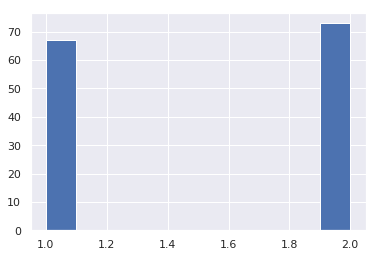

In [73]:
combined['accurancy'].hist()